In [6]:
import pandas as pd
import numpy as np

from sklearn.model_selection import train_test_split, StratifiedKFold, GridSearchCV
from sklearn.preprocessing import StandardScaler
from sklearn.ensemble import BaggingClassifier, RandomForestClassifier
from sklearn.neural_network import MLPClassifier
from sklearn.svm import SVC
from sklearn.tree import DecisionTreeClassifier
from sklearn.pipeline import Pipeline
from sklearn.metrics import (
    accuracy_score, recall_score, f1_score, roc_auc_score, roc_curve, classification_report
)
import matplotlib.pyplot as plt

# 1. Load dữ liệu
file_path = 'final_data.xlsx'  # Đường dẫn đến file Excel chứa dữ liệu
df = pd.read_excel(file_path)



Performing GridSearchCV for Bagged_Trees...
  Best CV AUC: 0.9493
  Best Params: {'clf__estimator__max_depth': 5, 'clf__max_samples': 0.5, 'clf__n_estimators': 100}

Performing GridSearchCV for Random_Forest...
  Best CV AUC: 0.9473
  Best Params: {'clf__max_depth': 5, 'clf__max_features': 'sqrt', 'clf__n_estimators': 100}

Performing GridSearchCV for MLP...
  Best CV AUC: 0.9323
  Best Params: {'clf__alpha': 0.001, 'clf__hidden_layer_sizes': (50,), 'clf__learning_rate_init': 0.01}

Performing GridSearchCV for SVM...
  Best CV AUC: 0.8477
  Best Params: {'clf__C': 10, 'clf__gamma': 'scale'}

=== Performance on Test Set: Bagged_Trees ===
Accuracy:  0.8910
Recall:    0.5517
F1 Score:  0.6531
AUC:       0.9519
Classification Report:
              precision    recall  f1-score   support

           0       0.90      0.97      0.94       254
           1       0.80      0.55      0.65        58

    accuracy                           0.89       312
   macro avg       0.85      0.76      0.

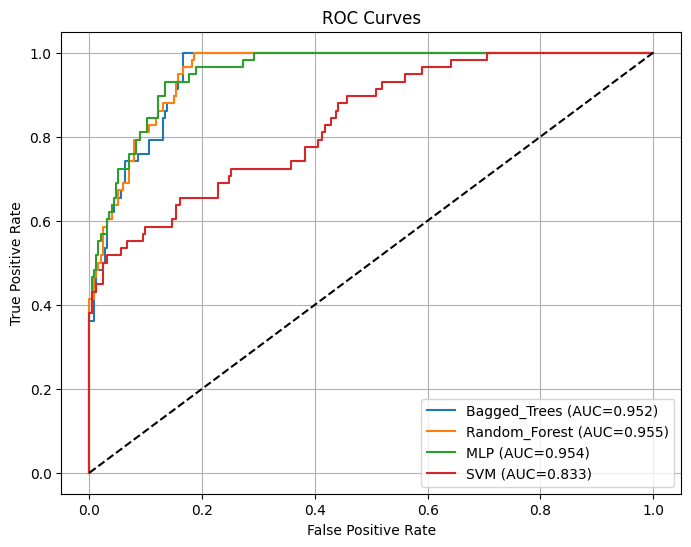

In [7]:
feature_cols = ['D1', 'D3', 'T1', 'T5', 'T7', 'H3']
X = df[feature_cols]
y = df['default']
symbols = df['symbol']

# 2. Split into train/test
X_train, X_test, y_train, y_test, sym_train, sym_test = train_test_split(
    X, y, symbols, test_size=0.2, random_state=42, stratify=y
)

# 3. Define pipelines (with scaler+classifier)
pipelines = {
    'Bagged_Trees': Pipeline([
        ('scaler', StandardScaler()),
        ('clf', BaggingClassifier(estimator=DecisionTreeClassifier(), random_state=42))
    ]),
    'Random_Forest': Pipeline([
        ('scaler', StandardScaler()),
        ('clf', RandomForestClassifier(random_state=42))
    ]),
    'MLP': Pipeline([
        ('scaler', StandardScaler()),
        ('clf', MLPClassifier(max_iter=500, random_state=42))
    ]),
    'SVM': Pipeline([
        ('scaler', StandardScaler()),
        ('clf', SVC(probability=True, random_state=42))
    ])
}

# 4. Hyperparameter grids
param_grids = {
    'Bagged_Trees': {
        'clf__n_estimators': [50, 100],
        'clf__max_samples': [0.5, 1.0],
        'clf__estimator__max_depth': [None, 5, 10]
    },
    'Random_Forest': {
        'clf__n_estimators': [100, 200],
        'clf__max_depth': [None, 5, 10],
        'clf__max_features': ['sqrt', 'log2']
    },
    'MLP': {
        'clf__hidden_layer_sizes': [(50,), (100,)],
        'clf__alpha': [0.0001, 0.001],
        'clf__learning_rate_init': [0.001, 0.01]
    },
    'SVM': {
        'clf__C': [0.1, 1, 10],
        'clf__gamma': ['scale', 'auto']
    }
}

# 5. Perform GridSearchCV for each model
cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)
best_estimators = {}
results_summary = []

for name in pipelines:
    print(f"\nPerforming GridSearchCV for {name}...")
    grid_search = GridSearchCV(
        pipelines[name],
        param_grids[name],
        scoring='roc_auc',
        cv=cv,
        n_jobs=-1,
        verbose=0
    )
    grid_search.fit(X_train, y_train)
    best_estimators[name] = grid_search.best_estimator_
    
    cv_results = grid_search.cv_results_
    best_mean_auc = grid_search.best_score_
    best_params = grid_search.best_params_
    results_summary.append((name, best_mean_auc, best_params))
    print(f"  Best CV AUC: {best_mean_auc:.4f}")
    print(f"  Best Params: {best_params}")

# 6. Evaluate best models on test set
evaluation = []

plt.figure(figsize=(8, 6))

for name, estimator in best_estimators.items():
    # Predict on test set
    y_pred = estimator.predict(X_test)
    y_proba = estimator.predict_proba(X_test)[:, 1]
    
    acc = accuracy_score(y_test, y_pred)
    rec = recall_score(y_test, y_pred)
    f1 = f1_score(y_test, y_pred)
    auc = roc_auc_score(y_test, y_proba)
    
    # ROC curve
    fpr, tpr, _ = roc_curve(y_test, y_proba)
    plt.plot(fpr, tpr, label=f"{name} (AUC={auc:.3f})")
    
    evaluation.append((name, acc, rec, f1, auc))
    print(f"\n=== Performance on Test Set: {name} ===")
    print(f"Accuracy:  {acc:.4f}")
    print(f"Recall:    {rec:.4f}")
    print(f"F1 Score:  {f1:.4f}")
    print(f"AUC:       {auc:.4f}")
    print("Classification Report:")
    print(classification_report(y_test, y_pred))

# Plot ROC curves
plt.plot([0, 1], [0, 1], 'k--')
plt.title("ROC Curves")
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.legend(loc="lower right")
plt.grid(True)
plt.show()

In [8]:
# 7. Select best model (by highest AUC on test)
best_model_name, _, _, _, _ = max(evaluation, key=lambda x: x[4])
best_model = best_estimators[best_model_name]
print(f"\nSelected Model: {best_model_name}")

# 8. Refit best model on full data (train+test) and predict PD for all symbols
best_model.fit(X, y)
probs_full = best_model.predict_proba(X)[:, 1]

df_results = pd.DataFrame({
    'symbol': symbols,
    'PD': probs_full
})

# 9. Assign 20 S&P credit ratings
labels_20 = [
    'AAA',
    'AA+','AA','AA-',
    'A+','A','A-',
    'BBB+','BBB','BBB-',
    'BB+','BB','BB-',
    'B+','B','B-',
    'CCC+','CCC','CCC-',
    'CC'
]
bins_20 = np.linspace(0.0, 1.0, num=21)
df_results['Credit_Rating_20'] = pd.cut(
    df_results['PD'],
    bins=bins_20,
    labels=labels_20,
    include_lowest=True
)
df_results = df_results.sort_values(by='PD', ascending=False).reset_index(drop=True)
df_results


Selected Model: Random_Forest


,symbol,PD,Credit_Rating_20
0,X77,0.999907,CC
1,HLY,0.999907,CC
2,SSF,0.999907,CC
3,AVF,0.999907,CC
4,CMI,0.999907,CC
...,...,...,...
1555,TNC,0.001832,AAA
1556,AAM,0.001832,AAA
1557,PRO,0.001832,AAA
1558,TRC,0.001777,AAA


In [ ]:
# 2. Tách tính năng (X) và nhãn (y)
feature_cols = ['D1', 'D3', 'T1', 'T5', 'T7', 'H3']
X = df[feature_cols]
y = df['default']
symbols = df['symbol']  # lưu để gắn kết kết quả sau

# 3. Khởi tạo các pipeline: StandardScaler + mô hình
# 3.1 Bagged Decision Trees (chú ý sửa base_estimator → estimator)
pipeline_bagged = Pipeline([
    ('scaler', StandardScaler()),
    ('clf', BaggingClassifier(
        estimator=DecisionTreeClassifier(),  # đã chỉnh
        n_estimators=100,
        random_state=42
    ))
])

# 3.2 Random Forest
pipeline_rf = Pipeline([
    ('scaler', StandardScaler()),
    ('clf', RandomForestClassifier(
        n_estimators=100,
        random_state=42
    ))
])

# 3.3 Multilayer Perceptron
pipeline_mlp = Pipeline([
    ('scaler', StandardScaler()),
    ('clf', MLPClassifier(
        hidden_layer_sizes=(50,),
        activation='relu',
        max_iter=500,
        random_state=42
    ))
])

# 3.4 Support Vector Machine (với xác suất)
pipeline_svm = Pipeline([
    ('scaler', StandardScaler()),
    ('clf', SVC(
        kernel='rbf',
        probability=True,
        random_state=42
    ))
])

models = {
    'Bagged_Trees': pipeline_bagged,
    'Random_Forest': pipeline_rf,
    'MLP': pipeline_mlp,
    'SVM': pipeline_svm
}

# 4. Đánh giá bằng Stratified 10-fold CV (accuracy)
cv = StratifiedKFold(n_splits=10, shuffle=True, random_state=42)

print("\n=== Cross-Validation Accuracy ===")
for name, pipeline in models.items():
    scores = cross_val_score(pipeline, X, y, cv=cv, scoring='accuracy')
    print(f"{name}: Mean = {scores.mean():.4f}, Std = {scores.std():.4f}")

# 5. Huấn luyện mô hình trên toàn bộ dữ liệu và dự báo xác suất vỡ nợ
best_model_name = 'Random_Forest'
best_pipeline = models[best_model_name]
best_pipeline.fit(X, y)

# Dự báo xác suất vỡ nợ (PD) cho từng công ty
probs = best_pipeline.predict_proba(X)[:, 1]  # xác suất class=1 (vỡ nợ)
df_results = pd.DataFrame({
    'symbol': symbols,
    'PD': probs
})

# 6. Gán hạng tín dụng mẫu (credit tiers) dựa vào PD
bins = np.linspace(0.0, 1.0, num=21) 
labels = [
    'AAA',
    'AA+','AA','AA-',
    'A+','A','A-',
    'BBB+','BBB','BBB-',
    'BB+','BB','BB-',
    'B+','B','B-',
    'CCC+','CCC','CCC-',
    'CC'
]
df_results['Credit_Rating_20'] = pd.cut(df_results['PD'],
                                        bins=bins,
                                        labels=labels,
                                        include_lowest=True)

# Sắp xếp theo PD giảm dần
df_results = df_results.sort_values(by='PD', ascending=False).reset_index(drop=True)
df_results.to_excel('credit_ratings_results.xlsx', index=False)


# 7. (Tùy chọn) Báo cáo classification_report của mô hình trên tập huấn luyện
# from sklearn.model_selection import train_test_split
# X_train, X_test, y_train, y_test, sym_train, sym_test = train_test_split(
#    X, y, symbols, test_size=0.2, random_state=42, stratify=y
# )
# best_pipeline.fit(X_train, y_train)
# y_pred = best_pipeline.predict(X_test)
# print("\n=== Classification Report on Hold-out Test ===")
# print(classification_report(y_test, y_pred))




=== Cross-Validation Accuracy ===
Bagged_Trees: Mean = 0.8955, Std = 0.0215
Random_Forest: Mean = 0.8904, Std = 0.0241


C:\Users\Administrator\AppData\Roaming\Python\Python312\site-packages\sklearn\neural_network\_multilayer_perceptron.py:690: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (500) reached and the optimization hasn't converged yet.
  warnings.warn(


MLP: Mean = 0.8750, Std = 0.0132
SVM: Mean = 0.8417, Std = 0.0081


,symbol,PD,Credit_Rating_20
0,X77,1.0,CC
1,VLF,1.0,CC
2,BT6,1.0,CC
3,GTT,1.0,CC
4,TS4,1.0,CC
...,...,...,...
1555,PSB,0.0,AAA
1556,BVL,0.0,AAA
1557,DHC,0.0,AAA
1558,CTP,0.0,AAA


In [9]:
df_results.to_excel('credit_ratings_results.xlsx', index=False)